## This notebook
- uses the `hwwprocessor_nocuts` processor which doesn't apply any cuts but saves the cuts as bools for us to test and cross-check
- runs over HWW semileptonic sample... one root file...
- makes stacked hist plots to compare the different cuts
- makes 2d plots to cross-check any pair of variables (e.g. lep_pt vs jet_pt)

In [1]:
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea import nanoevents
from coffea import processor
import time

import argparse
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
import pickle as pkl
import pandas as pd
import os
import sys
sys.path.append("../")

from collections import defaultdict
import pickle as pkl
import pyarrow as pa
import awkward as ak
import numpy as np
import pandas as pd
import json
import os
import shutil
import pathlib
from typing import List, Optional
import pyarrow.parquet as pq

from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection
from boostedhiggs.utils import match_HWW
from boostedhiggs.btag import btagWPs
from boostedhiggs.btag import BTagCorrector

import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
from hist.intervals import clopper_pearson_interval

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
job_name = '/0-1'
channels=['ele', 'mu', 'had']
sample = "GluGluHToWWToLNuQQ"

# Run the processor

In [3]:
# define the configuration and processor

fileset = {}
print(f"Processing: {sample}")
fileset[sample] = [f"../datafiles/{sample}/{sample}_1.root"]

outfiles = "./" + sample + "/"

# remove output directory to store fresh samples
if os.path.exists(outfiles):
    shutil.rmtree(outfiles)

from boostedhiggs.hwwprocessor_nocuts import HwwProcessor_nocuts
p = HwwProcessor_nocuts(year='2017', channels=channels, output_location=outfiles + job_name)

executor = processor.IterativeExecutor(status=True)
run = processor.Runner(
    executor=executor, savemetrics=True, schema=nanoevents.NanoAODSchema, chunksize=10000
)

out, metrics = run(
fileset, "Events", processor_instance=p
)

# dump to pickle
filehandler = open(outfiles + job_name + '.pkl', "wb")
pkl.dump(out, filehandler)
filehandler.close()

# merge parquet
for ch in channels:
    data = pd.read_parquet(outfiles + job_name + ch + '/parquet')
    data.to_parquet(outfiles + job_name + '_' + ch + '.parquet')

    # remove old parquet files
    os.system('rm -rf ' + outfiles + job_name + ch)

    data_jets = pd.read_parquet(outfiles + job_name + '/jets/' + ch + '/parquet')
    data_jets.to_parquet(outfiles + job_name + '_jets_' + ch + '.parquet')

# remove old parquet files
os.system('rm -rf ' + outfiles + job_name)        

Processing: GluGluHToWWToLNuQQ


Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/10 [00:00<?, ?chunk/s]

0

# Load the output files

In [4]:
data = {}
data_jets = {}
metadata = {}

data[sample] = {}
data_jets[sample] = {}

outfiles = "./" + sample + "/"

for ch in channels:
    data[sample][ch] = pq.read_table(outfiles + job_name + '_' + ch + '.parquet').to_pandas()
    data_jets[sample][ch] = pq.read_table(outfiles + job_name + '_jets_' + ch + '.parquet').to_pandas()

with open(outfiles + job_name + '.pkl', 'rb') as f:
    metadata[sample] = pkl.load(f)

# No cuts applied yet

### 1D-histograms with single axis

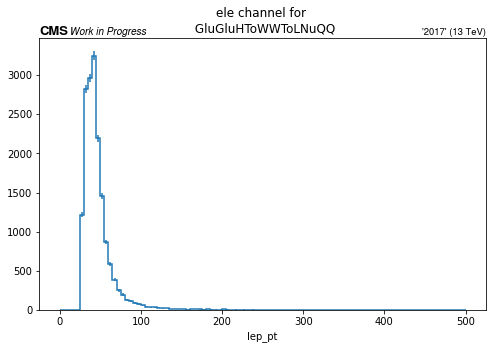

In [5]:
h = hist2.Hist(
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),
)
h.fill(data[sample]['ele']['lep_pt']
      )

odir = sample + "/plots/jets"

fig, ax = plt.subplots(figsize=(8, 5))
hep.histplot(h, ax=ax)
# ax.set_xlabel(f"{'btag_max'}")
ax.set_title(f'ele channel for \n {sample}')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)

if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/lep_pt_wth_btag_threshold.pdf')
## 1D-histograms with single axis:    plt.close()

# Register the cuts

In [6]:
normal_cuts = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met']
normal_plus_btag = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'anti_bjettag']
normal_plus_dR = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'leptonInJet']
normal_plus_btag_plus_dR = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'anti_bjettag', 'leptonInJet']

# make a cut dict to map the "cut label" to the actual cut
cut_dict = {}
cut_dict[sample] = {'lep_pt':            (data[sample]['ele']['leptonKin']>40),
                    'oneElectron':       (data[sample]['ele']['oneElectron']),
                    'notaus_ele':        (data[sample]['ele']['notaus_ele']),''
                    'ElectronIsolation': (data[sample]['ele']['ElectronIsolation']==1),
                    'mt_lep_met':        (data[sample]['ele']['mt_lep_met']==1),
                    'anti_bjettag':      (data[sample]['ele']['anti_bjettag']==1),
                    'leptonInJet':       (data[sample]['ele']['leptonInJet']==1)
                   }

def apply_cuts(sample, cuts = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'anti_bjettag', 'leptonInJet']):

    '''
    takes as input a list of cut names (any of the "cutdict" keys defined above)
    returns output as a boolean array to apply on the events
    '''
    for i, cut in enumerate(cuts):
        if i==0:
            combined_bool = cut_dict[sample][cut]
        else:
            combined_bool = pd.concat([combined_bool,cut_dict[sample][cut]], axis=1)
    
    if len(cuts)==1:
        return combined_bool
    return combined_bool.all(axis=1)

## 2D-plot

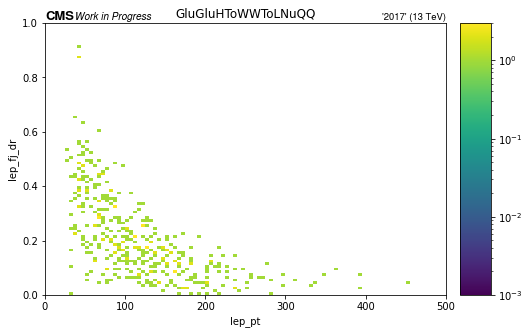

In [7]:
# btag vs lep_pt
h = hist2.Hist(
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),    
    hist2.axis.Regular(100,0, 1, name='lep_fj_dr', label='lep_fj_dr', flow=True),
)

h.fill(data[sample]['ele']['lep_pt'], data[sample]['ele']['lep_fj_dr'],
)

odir = sample + "/plots/"

fig, ax = plt.subplots(figsize=(8, 5))
hep.hist2dplot(h, ax=ax, norm=matplotlib.colors.LogNorm(vmin=1e-3))    
ax.set_title(f'{sample}')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)


if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/lep_fj_dr_vs_lep_pt_before_cuts.pdf')

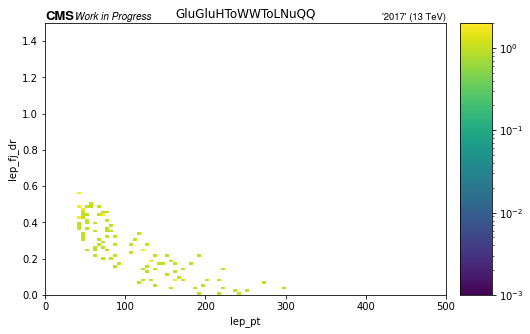

In [8]:
normal_cuts = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met']
normal_plus_btag = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'anti_bjettag']
normal_plus_dR = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'leptonInJet']
normal_plus_btag_plus_dR = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'anti_bjettag', 'leptonInJet']


cut_choice = normal_plus_btag_plus_dR

# btag vs lep_pt
h = hist2.Hist(
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),    
    hist2.axis.Regular(100,0, 1.5, name='lep_fj_dr', label='lep_fj_dr', flow=True),
)

h.fill(data[sample]['ele']['lep_pt'][apply_cuts(sample, cut_choice)], data[sample]['ele']['lep_fj_dr'][apply_cuts(sample, cut_choice)],
)

odir = sample + "/plots/"

fig, ax = plt.subplots(figsize=(8, 5))
hep.hist2dplot(h, ax=ax, norm=matplotlib.colors.LogNorm(vmin=1e-3))    
ax.set_title(f'{sample}')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)

if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/lep_fj_dr_vs_lep_pt_after_cuts.pdf')

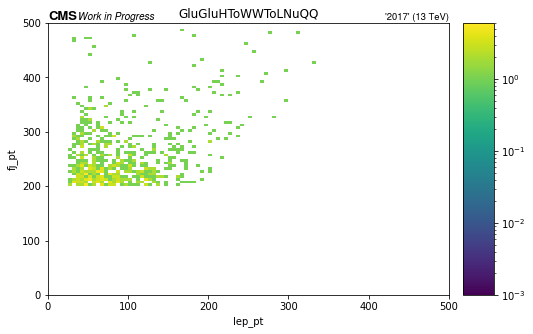

In [9]:
# btag vs lep_pt
h = hist2.Hist(
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),    
    hist2.axis.Regular(100,0, 500, name='fj_pt', label='fj_pt', flow=True),
)

h.fill(data[sample]['ele']['lep_pt'], data[sample]['ele']['fj_pt']
)

odir = sample + "/plots/"

fig, ax = plt.subplots(figsize=(8, 5))
hep.hist2dplot(h, ax=ax, norm=matplotlib.colors.LogNorm(vmin=1e-3))    
ax.set_title(f'{sample}')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)


if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/fj_pt_vs_lep_pt_before_cuts.pdf')

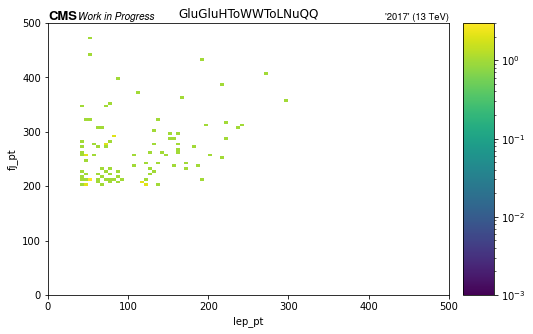

In [10]:
cut_choice = normal_plus_btag_plus_dR

# btag vs lep_pt
h = hist2.Hist(
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),    
    hist2.axis.Regular(100,0, 500, name='fj_pt', label='fj_pt', flow=True),
)

h.fill(data[sample]['ele']['lep_pt'][apply_cuts(sample, cut_choice)], data[sample]['ele']['fj_pt'][apply_cuts(sample, cut_choice)]
)

odir = sample + "/plots/"

fig, ax = plt.subplots(figsize=(8, 5))
hep.hist2dplot(h, ax=ax, norm=matplotlib.colors.LogNorm(vmin=1e-3))    
ax.set_title(f'{sample}')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)

if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/fj_pt_vs_lep_pt_after_cuts.pdf')